In [1]:
# [Problem 1] Creating a one-dimensional convolutional layer class with the number of channels limited to 1
import numpy as np

class WeightInitializer:
    @staticmethod
    def xavier(fan_in, fan_out):
        limit = np.sqrt(6 / (fan_in + fan_out))
        return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleConv1d:
    def __init__(self, filter_size, learning_rate=0.01):
        self.filter_size = filter_size
        self.weights = np.random.randn(filter_size) / np.sqrt(filter_size)  
        self.bias = np.zeros(1)
        self.learning_rate = learning_rate
        
        # Cache for backward pass
        self.x = None
        self.output_size = None
        
    def forward(self, x):
        """
        Forward pass for 1D convolution with single channel
        x: input array of shape (input_size,)
        Returns: output array of shape (output_size,)
        """
        input_size = x.shape[0]
        output_size = input_size - self.filter_size + 1 
        output = np.zeros(output_size)
        
        # Perform convolution
        for i in range(output_size):            
            window = x[i:i + self.filter_size]            
            output[i] = np.dot(window, self.weights) + self.bias
        
        
        self.x = x
        self.output_size = output_size
        
        return output
    
    def backward(self, delta):
        """
        Backward pass for 1D convolution
        delta: gradient from next layer, shape (output_size,)
        Returns: gradient for previous layer, shape (input_size,)
        """
        # Initialize gradients
        dw = np.zeros_like(self.weights)
        db = np.sum(delta)  # Gradient for bias
        dx = np.zeros_like(self.x)  # Gradient for input
        
        # Calculate gradient for weights
        for s in range(self.filter_size):
            for i in range(self.output_size):
                dw[s] += delta[i] * self.x[i + s]
        
        # Calculate gradient for input (to be passed to previous layer)
        for j in range(len(self.x)):
            for s in range(self.filter_size):                
                if 0 <= j - s < self.output_size:
                    dx[j] += delta[j - s] * self.weights[s]
        
        # Update weights and bias
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        
        return dx

In [2]:
# [Problem 2] Calculating the output size after 1D convolution
def calculate_output_size(input_size, filter_size, padding=0, stride=1):
    """
    Calculate the output size after 1D convolution
    
    Parameters:
    input_size (int): Size of the input (number of features)
    filter_size (int): Size of the filter
    padding (int): Number of padding elements on each side
    stride (int): Stride size
    
    Returns:
    int: Output size after convolution
    """
    return (input_size + 2 * padding - filter_size) // stride + 1

In [3]:
# [Problem 3] Experiment with 1D convolutional layers on small arrays
def verify_convolution():
    # Given values
    x = np.array([1, 2, 3, 4])
    w = np.array([3, 5, 7])
    b = np.array([1])
    
    # Expected results
    expected_a = np.array([35, 50])
    expected_delta_b = np.array([30])
    expected_delta_w = np.array([50, 80, 110])
    expected_delta_x = np.array([30, 110, 170, 140])
    
    # Forward pass calculation
    output_size = len(x) - len(w) + 1
    a = np.zeros(output_size)
    
    for i in range(output_size):
        window = x[i:i + len(w)]
        a[i] = np.dot(window, w) + b
    
    print("Forward pass:")
    print(f"Calculated a: {a}")
    print(f"Expected a: {expected_a}")
    print(f"Match: {np.array_equal(a, expected_a)}")
    
    # Backward pass calculation given delta_a
    delta_a = np.array([10, 20])
    
    # Calculate delta_b
    delta_b = np.sum(delta_a)
    
    # Calculate delta_w
    delta_w = np.zeros_like(w)
    for s in range(len(w)):
        for i in range(len(delta_a)):
            delta_w[s] += delta_a[i] * x[i + s]
    
    # Calculate delta_x
    delta_x = np.zeros_like(x)
    for j in range(len(x)):
        for s in range(len(w)):
            if 0 <= j - s < len(delta_a):
                delta_x[j] += delta_a[j - s] * w[s]
    
    print("\nBackward pass:")
    print(f"Calculated delta_b: {delta_b}")
    print(f"Expected delta_b: {expected_delta_b}")
    print(f"Match: {np.array_equal(np.array([delta_b]), expected_delta_b)}")
    
    print(f"Calculated delta_w: {delta_w}")
    print(f"Expected delta_w: {expected_delta_w}")
    print(f"Match: {np.array_equal(delta_w, expected_delta_w)}")
    
    print(f"Calculated delta_x: {delta_x}")
    print(f"Expected delta_x: {expected_delta_x}")
    print(f"Match: {np.array_equal(delta_x, expected_delta_x)}")

if __name__ == "__main__":
    verify_convolution()

Forward pass:
Calculated a: [35. 50.]
Expected a: [35 50]
Match: True

Backward pass:
Calculated delta_b: 30
Expected delta_b: [30]
Match: True
Calculated delta_w: [ 50  80 110]
Expected delta_w: [ 50  80 110]
Match: True
Calculated delta_x: [ 30 110 170 140]
Expected delta_x: [ 30 110 170 140]
Match: True


In [4]:
# [Problem 4] Creating a 1D convolutional layer class with no limit on the number of channels
import numpy as np

class Conv1d:
    def __init__(self, in_channels, out_channels, filter_size, learning_rate=0.01):
        """
        Initialize Conv1d layer
        
        Parameters:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        filter_size (int): Size of the filter
        learning_rate (float): Learning rate for weight updates
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.learning_rate = learning_rate
        
        # Initialize weights with Xavier initialization
        # Shape: (out_channels, in_channels, filter_size)
        limit = np.sqrt(6.0 / (in_channels * filter_size + out_channels))
        self.weights = np.random.uniform(-limit, limit, (out_channels, in_channels, filter_size))
        self.bias = np.zeros(out_channels)
        
        # Cache for backward pass
        self.x = None
        self.output_size = None
    
    def forward(self, x):
        """
        Forward pass for 1D convolution with multiple channels
        x: input array of shape (in_channels, input_size)
        Returns: output array of shape (out_channels, output_size)
        """
        in_channels, input_size = x.shape
        output_size = input_size - self.filter_size + 1  # No padding, stride=1
        output = np.zeros((self.out_channels, output_size))
        
        # Perform convolution for each output channel
        for out_ch in range(self.out_channels):
            for i in range(output_size):
                # For each position, sum over all input channels
                for in_ch in range(self.in_channels):
                    window = x[in_ch, i:i + self.filter_size]
                    output[out_ch, i] += np.dot(window, self.weights[out_ch, in_ch])
                output[out_ch, i] += self.bias[out_ch]
        
        # Save for backward pass
        self.x = x
        self.output_size = output_size
        
        return output
    
    def backward(self, delta):
        """
        Backward pass for 1D convolution with multiple channels
        delta: gradient from next layer, shape (out_channels, output_size)
        Returns: gradient for previous layer, shape (in_channels, input_size)
        """
        # Initialize gradients
        dw = np.zeros_like(self.weights)
        db = np.sum(delta, axis=1)  # Sum over output_size dimension for each output channel
        dx = np.zeros_like(self.x)  # Gradient for input
        
        # Calculate gradient for weights
        for out_ch in range(self.out_channels):
            for in_ch in range(self.in_channels):
                for s in range(self.filter_size):
                    for i in range(self.output_size):
                        dw[out_ch, in_ch, s] += delta[out_ch, i] * self.x[in_ch, i + s]
        
        # Calculate gradient for input (to be passed to previous layer)
        for in_ch in range(self.in_channels):
            for j in range(self.x.shape[1]):  # For each position in input
                for out_ch in range(self.out_channels):
                    for s in range(self.filter_size):
                        # Check if the index is valid for delta
                        if 0 <= j - s < self.output_size:
                            dx[in_ch, j] += delta[out_ch, j - s] * self.weights[out_ch, in_ch, s]
        
        # Update weights and bias
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        
        return dx
    
    def optimized_forward(self, x):
        """
        Optimized forward pass using array indexing
        x: input array of shape (in_channels, input_size)
        """
        _, input_size = x.shape
        output_size = input_size - self.filter_size + 1
        output = np.zeros((self.out_channels, output_size))
        
        # For each output position, create indices to extract windows
        for i in range(output_size):
            # Extract window for all input channels at position i
            window_indices = np.arange(i, i + self.filter_size)
            window = x[:, window_indices]  # Shape: (in_channels, filter_size)
            
            # For each output channel
            for out_ch in range(self.out_channels):
                # Element-wise multiplication and sum over input channels and filter positions
                output[out_ch, i] = np.sum(window * self.weights[out_ch]) + self.bias[out_ch]
        
        self.x = x
        self.output_size = output_size
        
        return output
    
    def very_optimized_forward(self, x):
        """
        Even more optimized forward pass using array broadcasting
        x: input array of shape (in_channels, input_size)
        """
        _, input_size = x.shape
        output_size = input_size - self.filter_size + 1
        output = np.zeros((self.out_channels, output_size))
        
        # Create a 3D array of windows for all positions
        # Shape: (output_size, in_channels, filter_size)
        windows = np.array([x[:, i:i+self.filter_size] for i in range(output_size)])
        
        # Perform batch dot product using broadcasting
        # Shape after broadcasting: (out_channels, output_size)
        for out_ch in range(self.out_channels):
            # Multiply and sum over input channels and filter positions
            output[out_ch] = np.sum(windows * self.weights[out_ch, :, :], axis=(1, 2)) + self.bias[out_ch]
        
        self.x = x
        self.output_size = output_size
        
        return output

def verify_multi_channel():
    x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])  
    w = np.ones((3, 2, 3))  
    b = np.array([1, 2, 3])  
    
    # Expected output: Shape (3, 2): (output_channels, features)
    expected_output = np.array([[16, 22], [17, 23], [18, 24]])  
    
    # Create Conv1d layer with preset weights and bias
    conv = Conv1d(in_channels=2, out_channels=3, filter_size=3, learning_rate=0.01)
    conv.weights = w
    conv.bias = b
    
    # Forward pass
    output = conv.forward(x)
    print("Multi-channel forward pass:")
    print(f"Calculated output: \n{output}")
    print(f"Expected output: \n{expected_output}")
    print(f"Match: {np.allclose(output, expected_output)}")
    
    # Test optimized forward pass
    optimized_output = conv.optimized_forward(x)
    print("\nOptimized multi-channel forward pass:")
    print(f"Calculated output: \n{optimized_output}")
    print(f"Match with expected: {np.allclose(optimized_output, expected_output)}")
    
    # Test very optimized forward pass
    very_optimized_output = conv.very_optimized_forward(x)
    print("\nVery optimized multi-channel forward pass:")
    print(f"Calculated output: \n{very_optimized_output}")
    print(f"Match with expected: {np.allclose(very_optimized_output, expected_output)}")

if __name__ == "__main__":
    verify_multi_channel()

Multi-channel forward pass:
Calculated output: 
[[16. 22.]
 [17. 23.]
 [18. 24.]]
Expected output: 
[[16 22]
 [17 23]
 [18 24]]
Match: True

Optimized multi-channel forward pass:
Calculated output: 
[[16. 22.]
 [17. 23.]
 [18. 24.]]
Match with expected: True

Very optimized multi-channel forward pass:
Calculated output: 
[[16. 22.]
 [17. 23.]
 [18. 24.]]
Match with expected: True


In [5]:
# [Problem 5] (Advanced) Implementing padding
class Conv1dWithPadding:
    def __init__(self, in_channels, out_channels, filter_size, padding=0, learning_rate=0.01):
        """
        Initialize Conv1d layer with padding support
        
        Parameters:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        filter_size (int): Size of the filter
        padding (int): Number of padding elements on each side
        learning_rate (float): Learning rate for weight updates
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.padding = padding
        self.learning_rate = learning_rate
        
        # Initialize weights with Xavier initialization
        limit = np.sqrt(6.0 / (in_channels * filter_size + out_channels))
        self.weights = np.random.uniform(-limit, limit, (out_channels, in_channels, filter_size))
        self.bias = np.zeros(out_channels)
        
        # Cache for backward pass
        self.x = None
        self.padded_x = None
        self.output_size = None
    
    def _pad_input(self, x):
        """Apply zero padding to input"""
        if self.padding == 0:
            return x
        
        padded_x = np.zeros((x.shape[0], x.shape[1] + 2 * self.padding))
        padded_x[:, self.padding:-self.padding] = x
        return padded_x
    
    def forward(self, x):
        """
        Forward pass for 1D convolution with padding
        x: input array of shape (in_channels, input_size)
        Returns: output array of shape (out_channels, output_size)
        """
        self.x = x  # Save original input for backward pass
        
        # Apply padding
        padded_x = self._pad_input(x)
        self.padded_x = padded_x  # Save padded input for backward pass
        
        # Calculate output size
        _, padded_input_size = padded_x.shape
        output_size = padded_input_size - self.filter_size + 1
        output = np.zeros((self.out_channels, output_size))
        
        # Perform convolution
        for out_ch in range(self.out_channels):
            for i in range(output_size):
                for in_ch in range(self.in_channels):
                    window = padded_x[in_ch, i:i + self.filter_size]
                    output[out_ch, i] += np.dot(window, self.weights[out_ch, in_ch])
                output[out_ch, i] += self.bias[out_ch]
        
        self.output_size = output_size
        return output
    
    def backward(self, delta):
        """
        Backward pass for 1D convolution with padding
        delta: gradient from next layer, shape (out_channels, output_size)
        Returns: gradient for previous layer, shape (in_channels, input_size)
        """
        # Initialize gradients
        dw = np.zeros_like(self.weights)
        db = np.sum(delta, axis=1)
        dpadded_x = np.zeros_like(self.padded_x)
        
        # Calculate gradient for weights
        for out_ch in range(self.out_channels):
            for in_ch in range(self.in_channels):
                for s in range(self.filter_size):
                    for i in range(self.output_size):
                        dw[out_ch, in_ch, s] += delta[out_ch, i] * self.padded_x[in_ch, i + s]
        
        # Calculate gradient for padded input
        for in_ch in range(self.in_channels):
            for j in range(self.padded_x.shape[1]):
                for out_ch in range(self.out_channels):
                    for s in range(self.filter_size):
                        if 0 <= j - s < self.output_size:
                            dpadded_x[in_ch, j] += delta[out_ch, j - s] * self.weights[out_ch, in_ch, s]
        
        # Extract gradient for original input (remove padding)
        if self.padding > 0:
            dx = dpadded_x[:, self.padding:-self.padding]
        else:
            dx = dpadded_x
        
        # Update weights and bias
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        
        return dx

In [6]:
# [Problem 6] (Advanced problem) Dealing with mini-batches
import numpy as np

class Conv1dWithBatches:
    def __init__(self, in_channels, out_channels, filter_size, padding=0, stride=1, learning_rate=0.01):
        """
        Initialize Conv1d layer with mini-batch support
        
        Parameters:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        filter_size (int): Size of the filter
        padding (int): Number of padding elements on each side
        stride (int): Stride size
        learning_rate (float): Learning rate for weight updates
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.learning_rate = learning_rate
        
        # Initialize weights with Xavier initialization
        limit = np.sqrt(6.0 / (in_channels * filter_size + out_channels))
        self.weights = np.random.uniform(-limit, limit, (out_channels, in_channels, filter_size))
        self.bias = np.zeros(out_channels)
        
        # Cache for backward pass
        self.x = None
        self.padded_x = None
        self.output_size = None
    
    def _pad_input(self, x):
        """
        Apply zero padding to input
        x: input array of shape (batch_size, in_channels, input_size)
        """
        if self.padding == 0:
            return x
        
        batch_size, in_channels, input_size = x.shape
        padded_x = np.zeros((batch_size, in_channels, input_size + 2 * self.padding))
        padded_x[:, :, self.padding:-self.padding] = x
        return padded_x
    
    def forward(self, x):
        """
        Forward pass for 1D convolution with mini-batch support
        x: input array of shape (batch_size, in_channels, input_size)
        Returns: output array of shape (batch_size, out_channels, output_size)
        """
        self.x = x          
        
        padded_x = self._pad_input(x)
        self.padded_x = padded_x
        
        # Calculate output size
        batch_size, _, padded_input_size = padded_x.shape
        output_size = (padded_input_size - self.filter_size) // self.stride + 1
        output = np.zeros((batch_size, self.out_channels, output_size))
        
        # Perform convolution for each sample in the batch
        for batch_idx in range(batch_size):
            for out_ch in range(self.out_channels):
                for i in range(output_size):
                    pos = i * self.stride  # Apply stride
                    for in_ch in range(self.in_channels):
                        window = padded_x[batch_idx, in_ch, pos:pos + self.filter_size]
                        output[batch_idx, out_ch, i] += np.dot(window, self.weights[out_ch, in_ch])
                    output[batch_idx, out_ch, i] += self.bias[out_ch]
        
        self.output_size = output_size
        return output
    
    def backward(self, delta):
        """
        Backward pass for 1D convolution with mini-batch support
        delta: gradient from next layer, shape (batch_size, out_channels, output_size)
        Returns: gradient for previous layer, shape (batch_size, in_channels, input_size)
        """
        batch_size = delta.shape[0]
        
        # Initialize gradients
        dw = np.zeros_like(self.weights)
        db = np.sum(delta, axis=(0, 2))  
        dpadded_x = np.zeros_like(self.padded_x)
        
        # Calculate gradient for weights (accumulate over batch)
        for batch_idx in range(batch_size):
            for out_ch in range(self.out_channels):
                for in_ch in range(self.in_channels):
                    for s in range(self.filter_size):
                        for i in range(self.output_size):
                            pos = i * self.stride
                            dw[out_ch, in_ch, s] += delta[batch_idx, out_ch, i] * self.padded_x[batch_idx, in_ch, pos + s]
        
        # Calculate gradient for padded input
        for batch_idx in range(batch_size):
            for in_ch in range(self.in_channels):
                for j in range(self.padded_x.shape[2]):
                    for out_ch in range(self.out_channels):
                        for s in range(self.filter_size):
                            
                            for i in range(self.output_size):
                                pos = i * self.stride
                                if pos <= j < pos + self.filter_size:
                                    filter_idx = j - pos
                                    if 0 <= filter_idx < self.filter_size:
                                        dpadded_x[batch_idx, in_ch, j] += delta[batch_idx, out_ch, i] * self.weights[out_ch, in_ch, filter_idx]        
        
        if self.padding > 0:
            dx = dpadded_x[:, :, self.padding:-self.padding]
        else:
            dx = dpadded_x
        
        # Update weights and bias using the average gradient over the batch
        self.weights -= self.learning_rate * dw / batch_size
        self.bias -= self.learning_rate * db / batch_size
        
        return dx

In [7]:
# [Problem 7] (Advanced Task) Any number of strides
import numpy as np

def verify_stride():
    # Create a simple 1D input with batch size 1, 1 channel, and 8 features
    x = np.array([[[1, 2, 3, 4, 5, 6, 7, 8]]])  # Shape: (1, 1, 8)
    
    # Create a filter with 1 output channel, 1 input channel, filter size 3
    w = np.array([[[1, 2, 3]]])  # Shape: (1, 1, 3)
    
    # Create bias for 1 output channel
    b = np.array([0])
    
    # Calculate expected output for stride=2, no padding
    # Output size = (8 - 3) // 2 + 1 = 3
    # Positions: 0, 2, 4
    expected_output_stride2 = np.array([[[
        1*1 + 2*2 + 3*3,  # Position 0: 1*1 + 2*2 + 3*3 = 14
        3*1 + 4*2 + 5*3,  # Position 2: 3*1 + 4*2 + 5*3 = 26
        5*1 + 6*2 + 7*3   # Position 4: 5*1 + 6*2 + 7*3 = 38
    ]]])  # Expected: [[[14, 26, 38]]]
    
    # Create Conv1d layer with stride=2
    conv = Conv1dWithBatches(in_channels=1, out_channels=1, filter_size=3, stride=2)
    conv.weights = w
    conv.bias = b
    
    # Forward pass
    output = conv.forward(x)
    
    print("Stride=2 verification:")
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Calculated output: {output}")
    print(f"Expected output: {expected_output_stride2}")
    print(f"Match: {np.allclose(output, expected_output_stride2)}")

if __name__ == "__main__":
    verify_stride()

Stride=2 verification:
Input shape: (1, 1, 8)
Output shape: (1, 1, 3)
Calculated output: [[[14. 26. 38.]]]
Expected output: [[[14 26 38]]]
Match: True


Loading MNIST dataset...
Train set: (3000, 784), Test set: (500, 784)
Training CNN model...
Training on 3000 samples with 47 batches per epoch
Epoch 1/5, Loss: 2.8273, Val Acc: 0.1280, Time: 402.76s
Epoch 2/5, Loss: 2.5913, Val Acc: 0.1980, Time: 398.57s
Epoch 3/5, Loss: 2.3886, Val Acc: 0.2900, Time: 400.20s
Epoch 4/5, Loss: 2.2138, Val Acc: 0.3680, Time: 444.78s
Epoch 5/5, Loss: 2.0620, Val Acc: 0.4220, Time: 404.48s

Final test accuracy: 0.4220


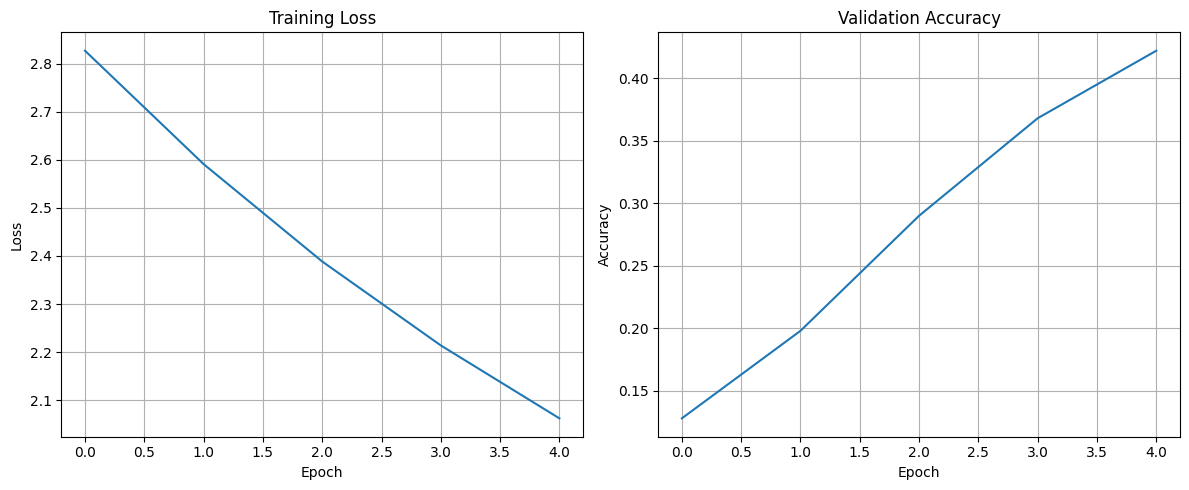


Sample predictions:
True: 6, Predicted: 6
True: 9, Predicted: 9
True: 2, Predicted: 4
True: 5, Predicted: 5
True: 3, Predicted: 3
True: 5, Predicted: 9
True: 7, Predicted: 7
True: 5, Predicted: 3
True: 2, Predicted: 3
True: 4, Predicted: 0


In [8]:
# [Problem 8] Learning and estimation
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

class Conv1dOptimized:
    def __init__(self, in_channels, out_channels, filter_size, learning_rate=0.01):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.learning_rate = learning_rate
        
        # Xavier initialization
        limit = np.sqrt(6.0 / (in_channels * filter_size + out_channels))
        self.weights = np.random.uniform(-limit, limit, (out_channels, in_channels, filter_size))
        self.bias = np.zeros(out_channels)
        
        # Cache for backward pass
        self.x = None
        self.output_size = None
    
    def forward(self, x):
        batch_size, in_channels, input_size = x.shape
        output_size = input_size - self.filter_size + 1
        output = np.zeros((batch_size, self.out_channels, output_size))
        
        # Using optimized numpy operations
        for i in range(output_size):
            # Extract window for all input channels at position i
            window = x[:, :, i:i+self.filter_size]  # Shape: (batch_size, in_channels, filter_size)
            
            # For each output channel
            for out_ch in range(self.out_channels):
                # Sum over input channels and filter positions
                output[:, out_ch, i] = np.sum(window * self.weights[out_ch], axis=(1, 2)) + self.bias[out_ch]
        
        self.x = x
        self.output_size = output_size
        
        return output
    
    def backward(self, delta):
        batch_size = delta.shape[0]
        dw = np.zeros_like(self.weights)
        db = np.sum(delta, axis=(0, 2))
        dx = np.zeros_like(self.x)
        
        # Calculate gradients using vectorized operations where possible
        for out_ch in range(self.out_channels):
            for in_ch in range(self.in_channels):
                for s in range(self.filter_size):
                    # For each position in the filter, sum the contribution across all batches and positions
                    for i in range(self.output_size):
                        dw[out_ch, in_ch, s] += np.sum(delta[:, out_ch, i] * self.x[:, in_ch, i+s])
        
        # Calculate input gradients
        for b in range(batch_size):
            for j in range(self.x.shape[2]):
                for out_ch in range(self.out_channels):
                    for s in range(self.filter_size):
                        if 0 <= j - s < self.output_size:
                            dx[b, :, j] += delta[b, out_ch, j-s] * self.weights[out_ch, :, s]
        
        # Update weights and bias
        self.weights -= self.learning_rate * dw / batch_size
        self.bias -= self.learning_rate * db / batch_size
        
        return dx

class FCLayer:
    def __init__(self, input_size, output_size, learning_rate=0.01, activation=None):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.activation = activation
        
        # Xavier initialization
        limit = np.sqrt(6 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.bias = np.zeros(output_size)
        
        # Cache
        self.x = None
        self.z = None
        self.a = None
    
    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.weights) + self.bias
        
        if self.activation == 'relu':
            self.a = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.a = 1 / (1 + np.exp(-np.clip(self.z, -709, 709)))
        else:
            self.a = self.z
            
        return self.a
    
    def backward(self, delta):
        batch_size = self.x.shape[0]
        
        if self.activation == 'relu':
            delta = delta * (self.z > 0)
        elif self.activation == 'sigmoid':
            sigmoid = 1 / (1 + np.exp(-np.clip(self.z, -709, 709)))
            delta = delta * sigmoid * (1 - sigmoid)
        
        dw = np.dot(self.x.T, delta) / batch_size
        db = np.sum(delta, axis=0) / batch_size
        dx = np.dot(delta, self.weights.T)
        
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        
        return dx

class OptimizedCNNClassifier:
    def __init__(self, conv_filter_size=3, conv_out_channels=4, hidden_size=50, output_size=10, 
                 learning_rate=0.01, batch_size=32, epochs=5):
        self.conv_filter_size = conv_filter_size
        self.conv_out_channels = conv_out_channels
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        
        # Layers will be initialized in fit
        self.conv_layer = None
        self.fc1 = None
        self.fc2 = None
        
        # History
        self.loss_history = []
        self.accuracy_history = []
    
    def _init_layers(self, input_shape):
        input_size = input_shape[1]
        
        # Initialize conv layer
        self.conv_layer = Conv1dOptimized(
            in_channels=1,
            out_channels=self.conv_out_channels,
            filter_size=self.conv_filter_size,
            learning_rate=self.learning_rate
        )
        
        # Calculate sizes
        conv_output_size = input_size - self.conv_filter_size + 1
        flattened_size = self.conv_out_channels * conv_output_size
        
        # Initialize FC layers
        self.fc1 = FCLayer(
            input_size=flattened_size,
            output_size=self.hidden_size,
            learning_rate=self.learning_rate,
            activation='relu'
        )
        
        self.fc2 = FCLayer(
            input_size=self.hidden_size,
            output_size=self.output_size,
            learning_rate=self.learning_rate
        )
    
    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true] + 1e-10)
        return np.mean(log_likelihood)
    
    def fit(self, X, y, X_val=None, y_val=None):
        # Initialize layers
        if self.conv_layer is None:
            self._init_layers(X.shape)
        
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / self.batch_size))
        
        print(f"Training on {n_samples} samples with {n_batches} batches per epoch")
        
        for epoch in range(self.epochs):
            start_time = time.time()
            
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            
            for batch in range(n_batches):
                # Get batch data
                start_idx = batch * self.batch_size
                end_idx = min((batch + 1) * self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Reshape for 1D convolution (batch_size, 1, input_size)
                X_reshaped = X_batch.reshape(X_batch.shape[0], 1, -1)
                
                # Forward pass
                conv_out = self.conv_layer.forward(X_reshaped)
                flattened = conv_out.reshape(X_batch.shape[0], -1)
                fc1_out = self.fc1.forward(flattened)
                fc2_out = self.fc2.forward(fc1_out)
                softmax_out = self._softmax(fc2_out)
                
                # Calculate loss
                batch_loss = self._cross_entropy_loss(softmax_out, y_batch)
                epoch_loss += batch_loss * (end_idx - start_idx) / n_samples
                
                # Backward pass
                # Gradient of cross-entropy loss with respect to softmax output
                delta_softmax = softmax_out.copy()
                delta_softmax[range(len(y_batch)), y_batch] -= 1
                delta_softmax /= len(y_batch)
                
                delta_fc2 = self.fc2.backward(delta_softmax)
                delta_fc1 = self.fc1.backward(delta_fc2)
                delta_conv = delta_fc1.reshape(conv_out.shape)
                self.conv_layer.backward(delta_conv)
            
            self.loss_history.append(epoch_loss)
            
            # Calculate validation accuracy
            if X_val is not None and y_val is not None:
                val_preds = self.predict(X_val)
                val_acc = np.mean(val_preds == y_val)
                self.accuracy_history.append(val_acc)
                
                epoch_time = time.time() - start_time
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
            else:
                epoch_time = time.time() - start_time
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s")
        
        return self
    
    def predict(self, X):
        # Reshape for 1D convolution
        X_reshaped = X.reshape(X.shape[0], 1, -1)
        
        # Forward pass
        conv_out = self.conv_layer.forward(X_reshaped)
        flattened = conv_out.reshape(X.shape[0], -1)
        fc1_out = self.fc1.forward(flattened)
        fc2_out = self.fc2.forward(fc1_out)
        softmax_out = self._softmax(fc2_out)
        
        # Get predictions
        return np.argmax(softmax_out, axis=1)
    
    def plot_learning_curves(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        
        if self.accuracy_history:
            plt.subplot(1, 2, 2)
            plt.plot(self.accuracy_history)
            plt.title('Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

def load_small_mnist_dataset(train_size=5000, test_size=1000):
    print("Loading MNIST dataset...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser="auto")
    
    # Scale features to [0, 1]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Convert labels to integers
    y = y.astype(int)
    
    # Take a small subset
    indices = np.random.permutation(len(X))
    X_subset = X[indices[:train_size+test_size]]
    y_subset = y[indices[:train_size+test_size]]
    
    # Split into train and test
    X_train = X_subset[:train_size]
    y_train = y_subset[:train_size]
    X_test = X_subset[train_size:train_size+test_size]
    y_test = y_subset[train_size:train_size+test_size]
    
    print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test


def run_mnist_cnn():    
    X_train, y_train, X_test, y_test = load_small_mnist_dataset(train_size=3000, test_size=500)
    
    # Create model with hyperparameters
    model = OptimizedCNNClassifier(
        conv_filter_size=5,  
        conv_out_channels=4,  
        hidden_size=64,     
        output_size=10,       
        learning_rate=0.01,   
        batch_size=64,        
        epochs=5              
    )
    
    # Train the model
    print("Training CNN model...")
    model.fit(X_train, y_train, X_test, y_test)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print(f"\nFinal test accuracy: {accuracy:.4f}")
    
    # Plot learning curves
    model.plot_learning_curves()
    
    # Display some example predictions
    print("\nSample predictions:")
    for i in range(10):
        print(f"True: {y_test[i]}, Predicted: {y_pred[i]}")
    
    return model

if __name__ == "__main__":
    run_mnist_cnn()